# **About this Project**
In this project, you will implement the CART (Classification and Regression Tree) algorithm. You will work with the Ionosphere Data Set from the UCI Machine Learning Repository, which consists of radar data from a system designed to target free electrons in the ionosphere, and a artificial "spiral" dataset. The first dataset will be used to determine if a radar return was "good" (i.e. a signal was returned) or "bad" (i.e. the signal passed straight through the ionosphere).

You will be using a regression tree with squared loss impurity to do classification. This is possible here because all classification problems can be framed as regression problems. You could also have used a classification tree with Gini impurity equivalently.



# **Implementing Regression Trees**
**Getting Started**

Before you get started, let's import a few packages that you will need. In addition, you will load two binary classification dataset - the spiral dataset and the ION dataset.

In [ ]:
import numpy as np
import pandas as pd
from pylab import *
from numpy.matlib import repmat
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import sys

%matplotlib inline

sys.path.append('/home/codio/workspace/.guides/hf')
from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.10.11


The code below generates spiral data using the trigonometric functions sine and cosine, then splits the data into train and test segments.

In [ ]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N) # generate a vector of "radius" values
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T # generate a curve that draws circles with increasing radius
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2

    # Now sample alternating values to generate the test and train sets.
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]

    return xTr, yTr, xTe, yTe

xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
print(f'Number of training points in spiral dataset: {xTrSpiral.shape[0]}')
print(f'Number of testing points in spiral dataset: {xTeSpiral.shape[0]}')
print(f'Number of features in spiral dataset: {xTrSpiral.shape[1]}')

Number of training points in spiral dataset: 150
Number of testing points in spiral dataset: 150
Number of features in spiral dataset: 2


Each data point  [𝐱]𝑖
  in the spiral data has 2 dimensions and the label  𝑦𝑖
  is either  −1
  or  +1
 . We can plot xTrSpiral to see the points, colored by the label they are associated with.

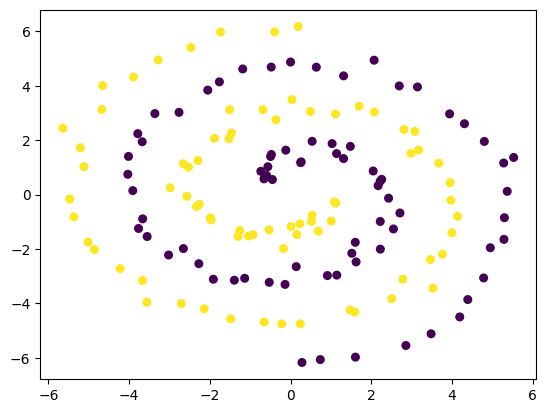

In [ ]:
plt.scatter(xTrSpiral[:, 0], xTrSpiral[:, 1], s=30, c=yTrSpiral)

The following code loads the ION dataset.

In [ ]:
# Load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")

# Load the training data
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()

# Load the test data
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

print(f'Number of training points in ION dataset: {xTrIon.shape[0]}')
print(f'Number of testing points in ION dataset: {xTeIon.shape[0]}')
print(f'Number of features in ION dataset: {xTrIon.shape[1]}')
print('Training set: (n x d matrix)')
TrIon_for_display = np.concatenate([yTrIon[:, None], xTrIon], axis=1)
TrIon_for_display = TrIon_for_display[TrIon_for_display[:, 0].argsort()]

display(pd.DataFrame(data=TrIon_for_display,
                     columns=['$y$'] + [f'$[\mathbf{{x}}]_{ {i+1} }$' for i in range(xTrIon.shape[1])]).round(2))

FileNotFoundError: ignored

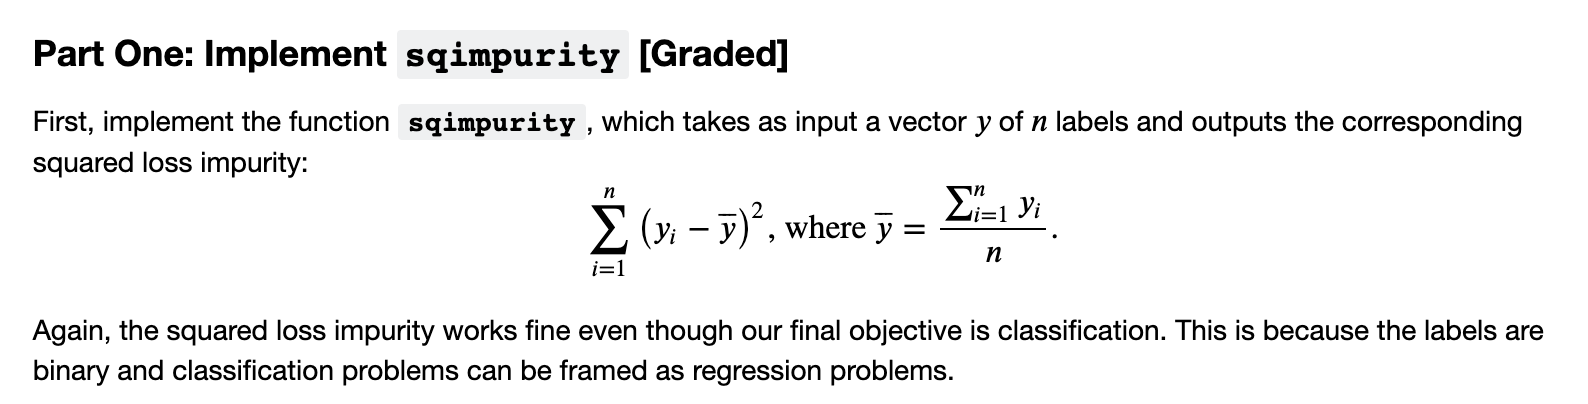

In [ ]:
def sqimpurity(yTr):
    """
    Computes the squared loss impurity (variance) of the labels.

    Input:
        yTr: n-dimensional vector of labels

    Output:
        squared loss impurity: weighted variance/squared loss impurity of the labels
    """

    N, = yTr.shape
    print(f'this is the number of labels: {N}')
    assert N > 0 # must have at least one sample
    impurity = 0

    mean = np.mean(yTr)
    squared = np.square(yTr - mean)
    impurity += np.sum(squared)

    return impurity

In [ ]:
yTr = np.array([1, -1, -1, 1, 1])

In [ ]:
sqimpurity(yTr)

this is the number of labels: 5


4.800000000000001

In [ ]:
def sqimpurity_test1():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isscalar(impurity)  # impurity should be scalar

def sqimpurity_test2():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr) # compute impurity
    return impurity >= 0 # impurity should be nonnegative

def sqimpurity_test3():
    yTr = np.ones(100) # generate an all one vector as labels
    impurity = sqimpurity(yTr) # compute impurity
    return np.isclose(impurity, 0) # impurity should be zero since the labels are homogeneous

def sqimpurity_test4():
    yTr = np.arange(-5, 6) # generate a vector with mean zero
    impurity = sqimpurity(yTr) # compute impurity
    sum_of_squares = np.sum(yTr ** 2)
    return np.isclose(impurity, sum_of_squares) # with mean zero, then the impurity should be the sum of squares

def sqimpurity_test5():
    yTr = np.random.randn(100) # generate random labels
    impurity = sqimpurity(yTr)
    impurity_grader = sqimpurity_grader(yTr)
    return np.isclose(impurity, impurity_grader)


Let's plot the shape of the impurity function. We vary the mixture of labels in a set of  𝑛
  labels and calculate the impurity of the labels. When the labels are mostly the same, the impurity should be low. When the labels are evenly split between  +1
  and  −1
 , the impurity should be the highest.

this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10
this is the number of labels: 10


,fraction_pos,impurity
0,1.0,0.0
1,0.9,3.6
2,0.8,6.4
3,0.7,8.4
4,0.6,9.6
5,0.5,10.0
6,0.4,9.6
7,0.3,8.4
8,0.2,6.4
9,0.1,3.6


Text(0, 0.5, 'Squared loss impurity of labels')

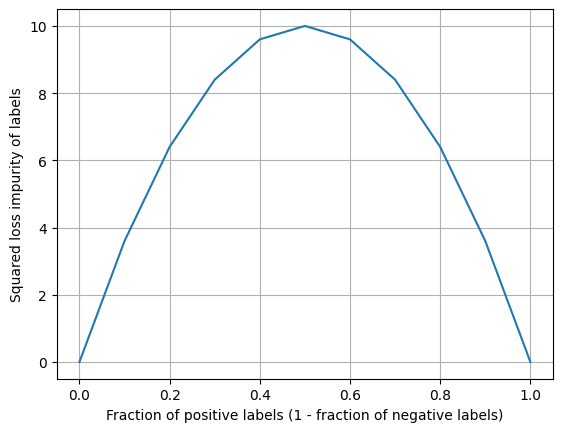

In [ ]:
size = 10
y = np.ones(size)
fraction_pos, impurities = [], []
for i in range(size):
    fraction_pos.append(sum([y == 1]) / size)
    impurities.append(sqimpurity(y))
    y[i] = -1
fraction_pos.append(sum([y == 1]) / size)
impurities.append(sqimpurity(y))

display(pd.DataFrame(data={'fraction_pos': fraction_pos, 'impurity': impurities}))
plt.plot(fraction_pos, impurities)
plt.grid()
plt.xlabel('Fraction of positive labels (1 - fraction of negative labels)')
plt.ylabel('Squared loss impurity of labels')

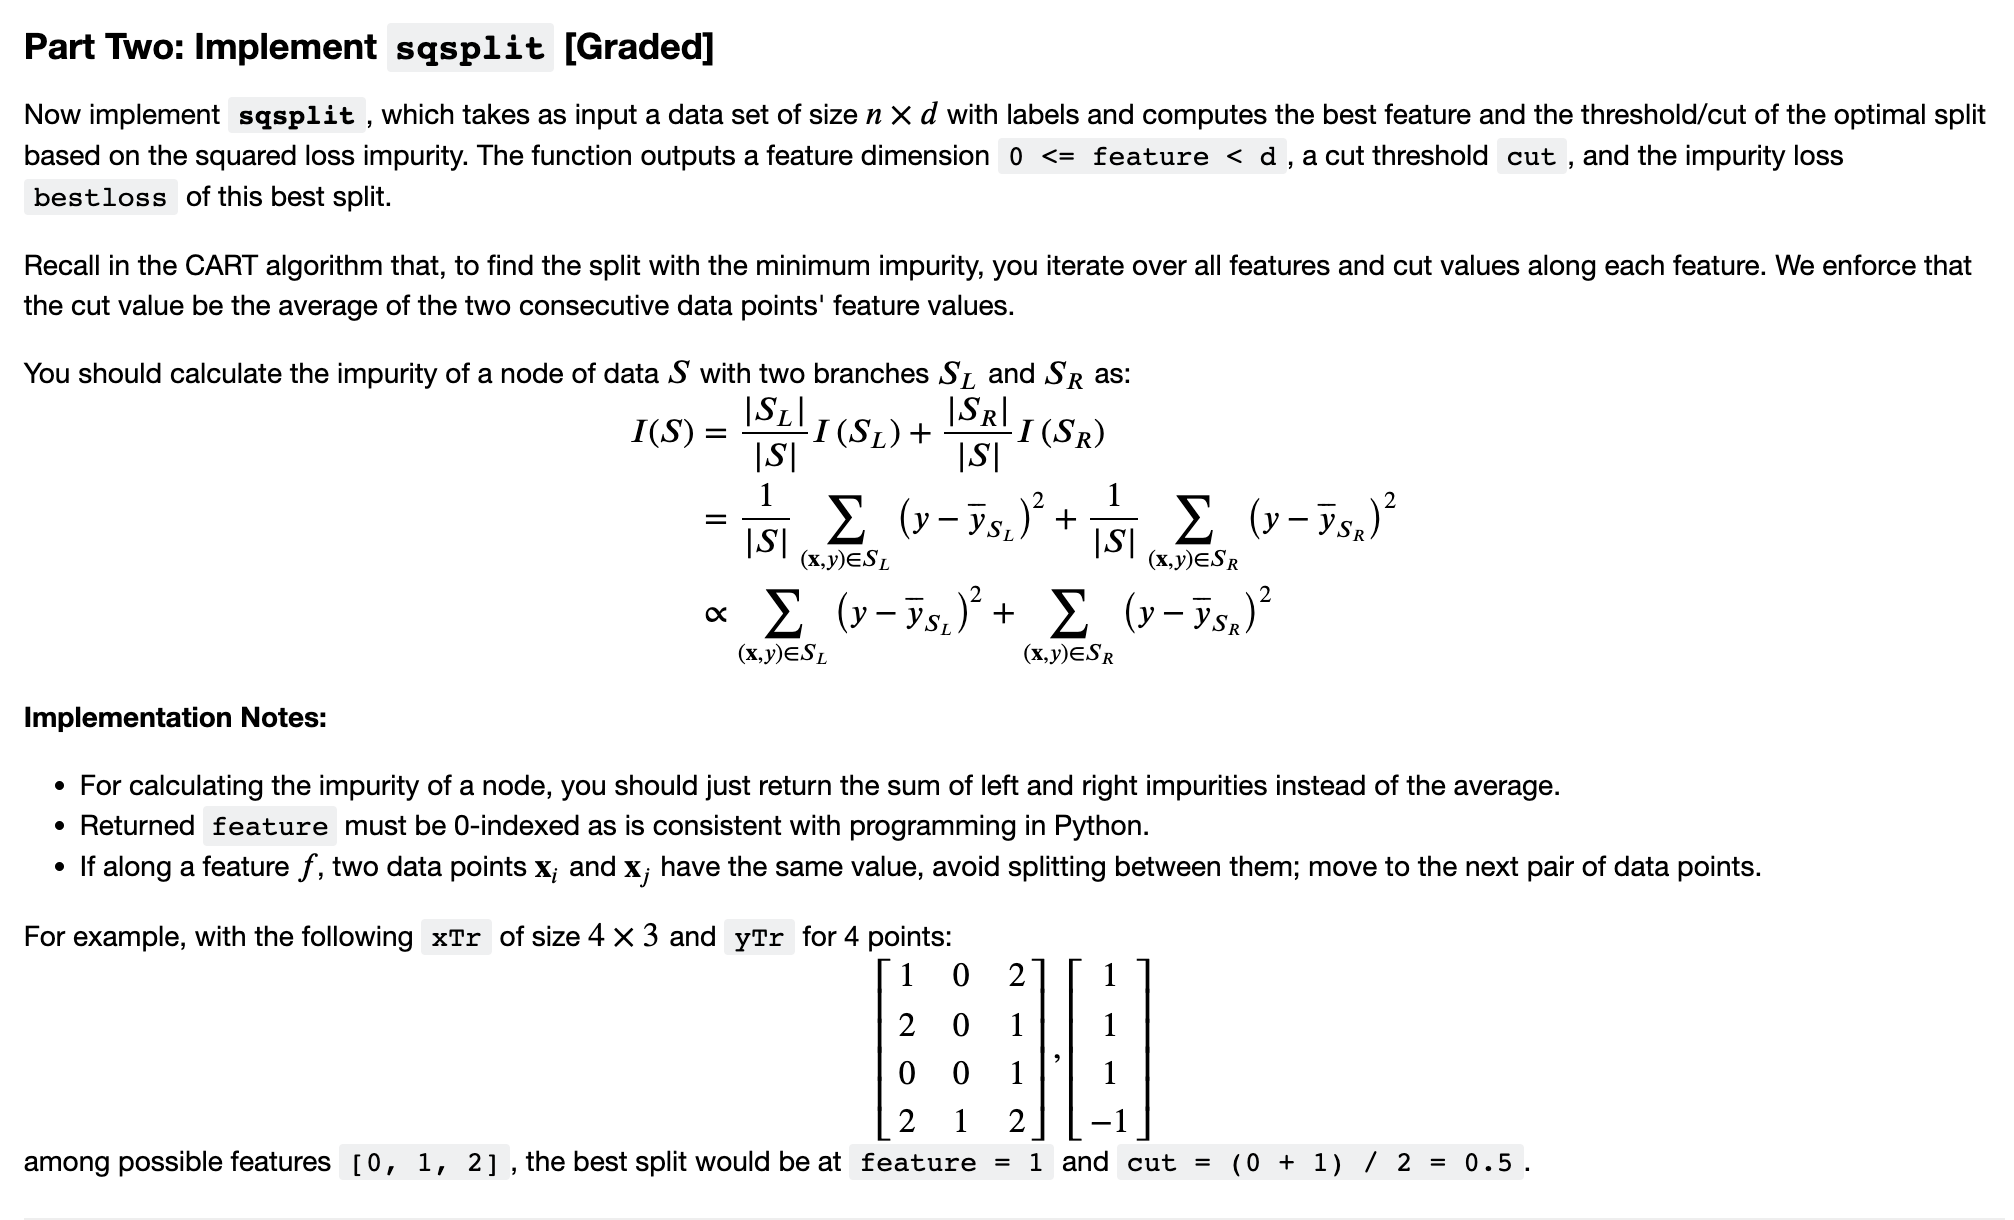

In [ ]:
xTr = np.array([[1,0,2],[2,0,1],[0,0,1],[2,1,2]])
yTr = np.array([1,1,1,-1])
print(f'xTr is: {xTr}')
print(f'yTr is: {yTr}')

xTr is: [[1 0 2]
 [2 0 1]
 [0 0 1]
 [2 1 2]]
yTr is: [ 1  1  1 -1]


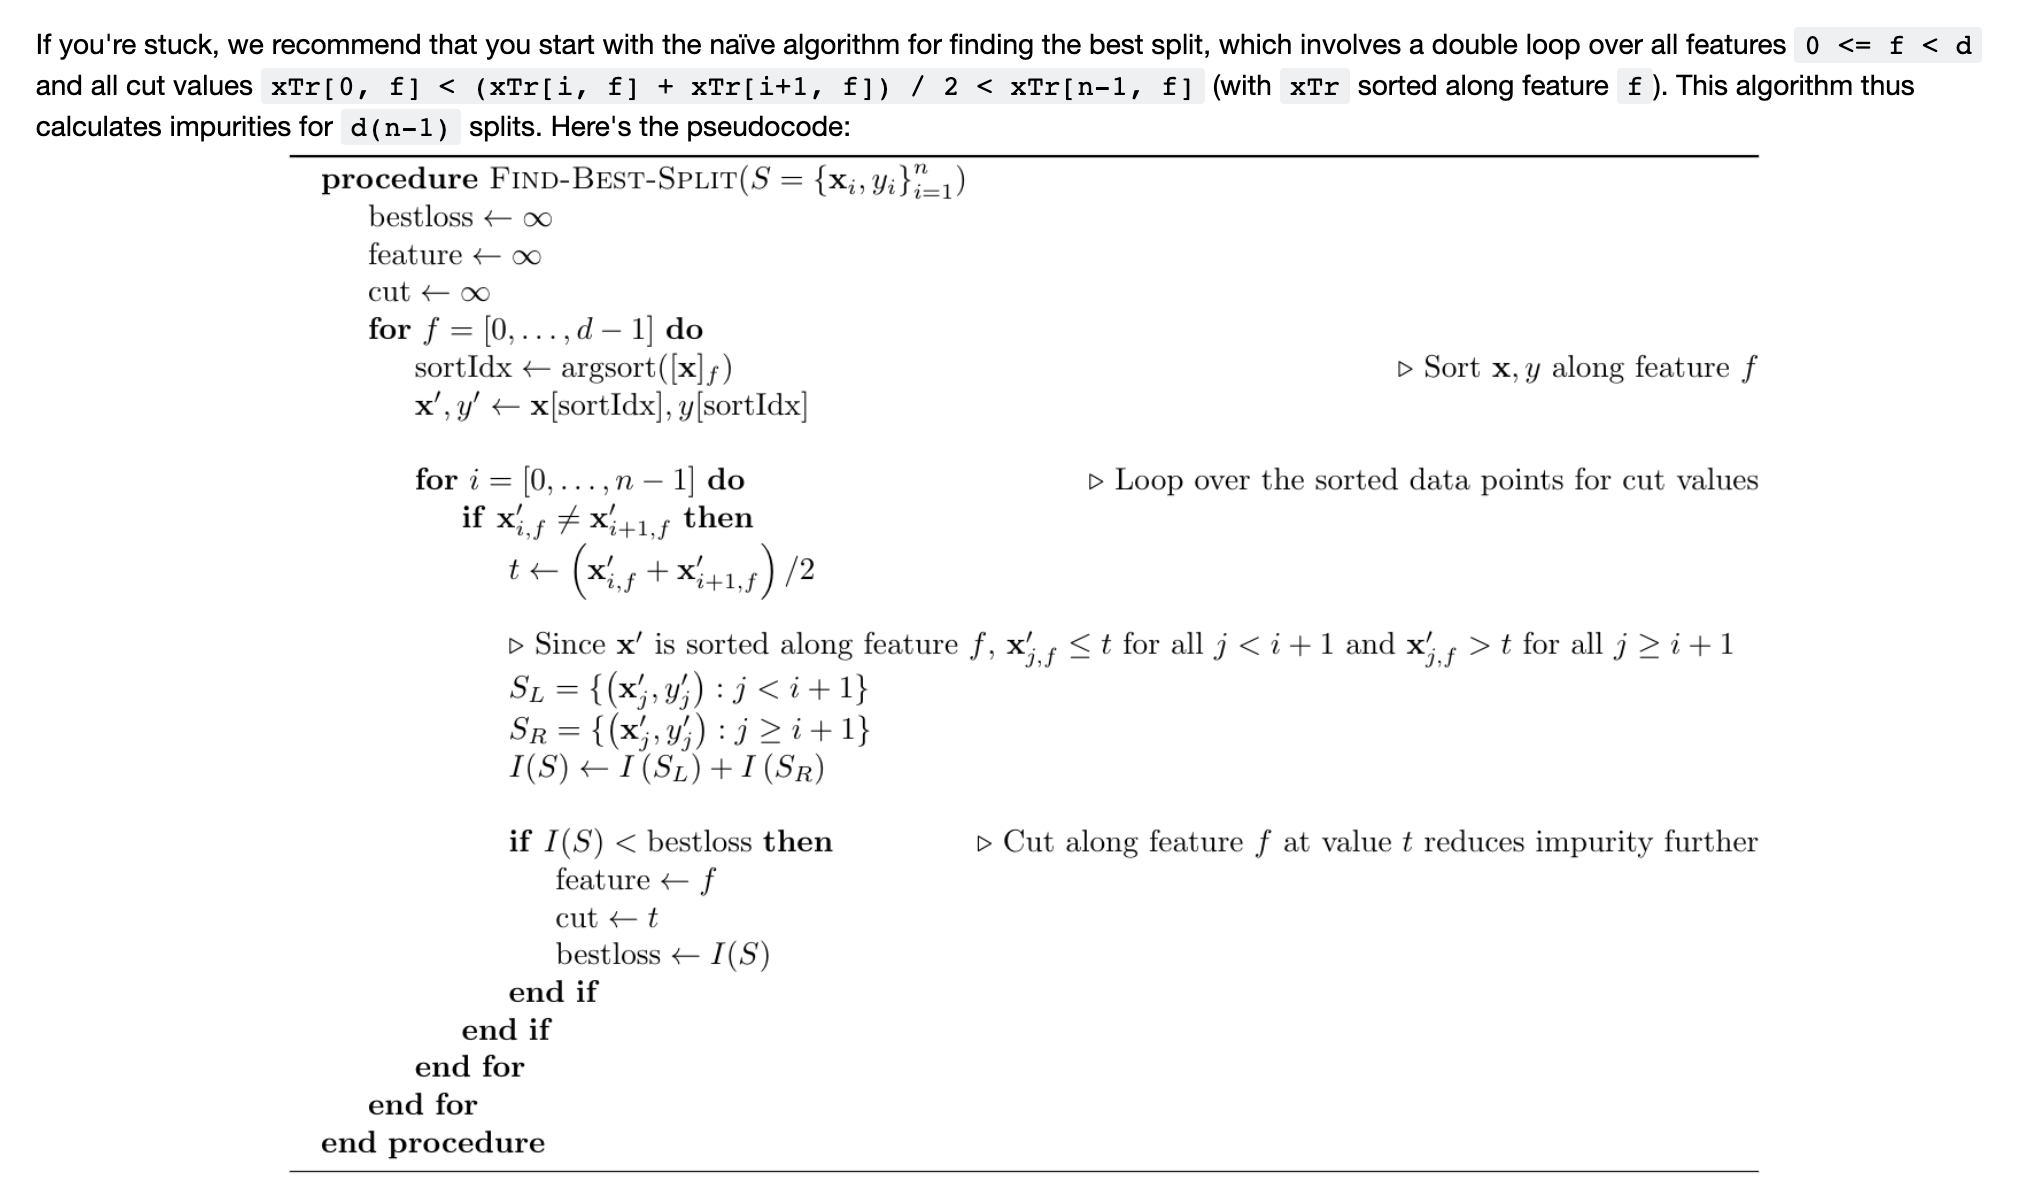

In [ ]:
def sqsplit(xTr, yTr):
    """
    Finds the best feature, cut value, and impurity for a split of (xTr, yTr) based on squared loss impurity.

    Input:
        xTr: n x d matrix of data points
        yTr: n-dimensional vector of labels

    Output:
        feature:  index of the best cut's feature (keep in mind this is 0-indexed)
        cut:      cut-value of the best cut
        bestloss: squared loss impurity of the best cut
    """
    n, d = xTr.shape
    assert d > 0 # must have at least one dimension
    assert n > 1 # must have at least two samples
    n = yTr.size

    bestloss = np.inf
    feature = np.inf
    cut = np.inf

    for f in range(0, d):
      sorted_x = xTr[xTr[:,f].argsort()]
      sorted_y = yTr[xTr[:,f].argsort()]
      xTr, yTr = sorted_x, sorted_y
      print(f'this is the: {f} column')

      for i in range(0, n-1):
        if xTr[i, f] != xTr[i+1, f]:
          t = (xTr[i,f] + xTr[i+1,f])/2
          print(f'this is the cut: {t} for this column:{f}')
          Sl = yTr[xTr[:,f]<t]
          Sr = yTr[xTr[:,f]>=t]
          print(f'this is the Sl: {Sl} dataset')
          print(f'this is the Sr: {Sr} dataset')
          impurity = sqimpurity(Sl) + sqimpurity(Sr)

          if impurity < bestloss:
            feature = f
            cut = t
            bestloss = impurity

    return feature, cut, bestloss

In [ ]:
sqsplit(xTr, yTr)

this is the: 0 column
this is the cut: 0.5 for this column:0
this is the Sl: [1] dataset
this is the Sr: [ 1  1 -1] dataset
this is the number of labels: 1
this is the number of labels: 3
this is the cut: 1.5 for this column:0
this is the Sl: [1 1] dataset
this is the Sr: [ 1 -1] dataset
this is the number of labels: 2
this is the number of labels: 2
this is the: 1 column
this is the cut: 0.5 for this column:1
this is the Sl: [1 1 1] dataset
this is the Sr: [-1] dataset
this is the number of labels: 3
this is the number of labels: 1
this is the: 2 column
this is the cut: 1.5 for this column:2
this is the Sl: [1 1] dataset
this is the Sr: [ 1 -1] dataset
this is the number of labels: 2
this is the number of labels: 2


(1, 0.5, 0.0)

In [ ]:
xTr

array([[1, 0, 2],
       [2, 0, 1],
       [0, 0, 1],
       [2, 1, 2]])

In [ ]:
xTr[2]

In [ ]:
Sl = []
Sl = np.append(xTr[:i,:], yTr[:i])
print(Sl)

[]


In [ ]:
sorted = xTr[xTr[:,0].argsort()]
print(sorted)

[[0 0 1]
 [1 0 2]
 [2 0 1]
 [2 1 2]]


In [ ]:
yTr

array([ 1,  1,  1, -1])

In [ ]:
sorted_y = yTr[xTr[:,0].argsort()]
sorted_y

array([ 1,  1,  1, -1])

In [ ]:
indexofsort=np.argsort(xTr[:,0],axis=-1,kind='stable')
indexofsort

array([2, 0, 1, 3])

In [ ]:
np.argsort(sorted)

array([[0, 1, 2],
       [1, 0, 2],
       [1, 2, 0],
       [1, 0, 2]])

In [ ]:
np.argsort(xTr, axis = 1)

array([[1, 0, 2],
       [1, 2, 0],
       [0, 1, 2],
       [1, 0, 2]])

In [ ]:
np.unravel_index(np.argsort(sorted, axis=-1), sorted.shape)

(array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 1, 2],
        [1, 0, 2],
        [1, 2, 0],
        [1, 0, 2]]))

In [ ]:
Sl = xTr[:3,:], yTr[:3]
Sl

(array([[1, 0, 2],
        [2, 0, 1],
        [0, 0, 1]]),
 array([1, 1, 1]))

In [ ]:
Sl = xTr[:3,:], yTr[:3]
Sl

(array([[1, 0, 2],
        [2, 0, 1],
        [0, 0, 1]]),
 array([1, 1, 1]))

In [ ]:
Sr = xTr[3:,:], yTr[3:]
Sr

(array([[2, 1, 2]]), array([-1]))

In [ ]:
 yTr[-1:].shape

(1,)

In [ ]:
sqimpurity(yTr[-1:])


1


0.0

In [ ]:
sqimpurity(yTr[3:])

1


0.0

In [ ]:
impurity = sqimpurity(yTr[:3]) + sqimpurity(yTr[3:])
impurity

3
1


0.0

In [ ]:
Sl = yTr[xTr[:,1]<0.5]
print(Sl)


[1 1 1]


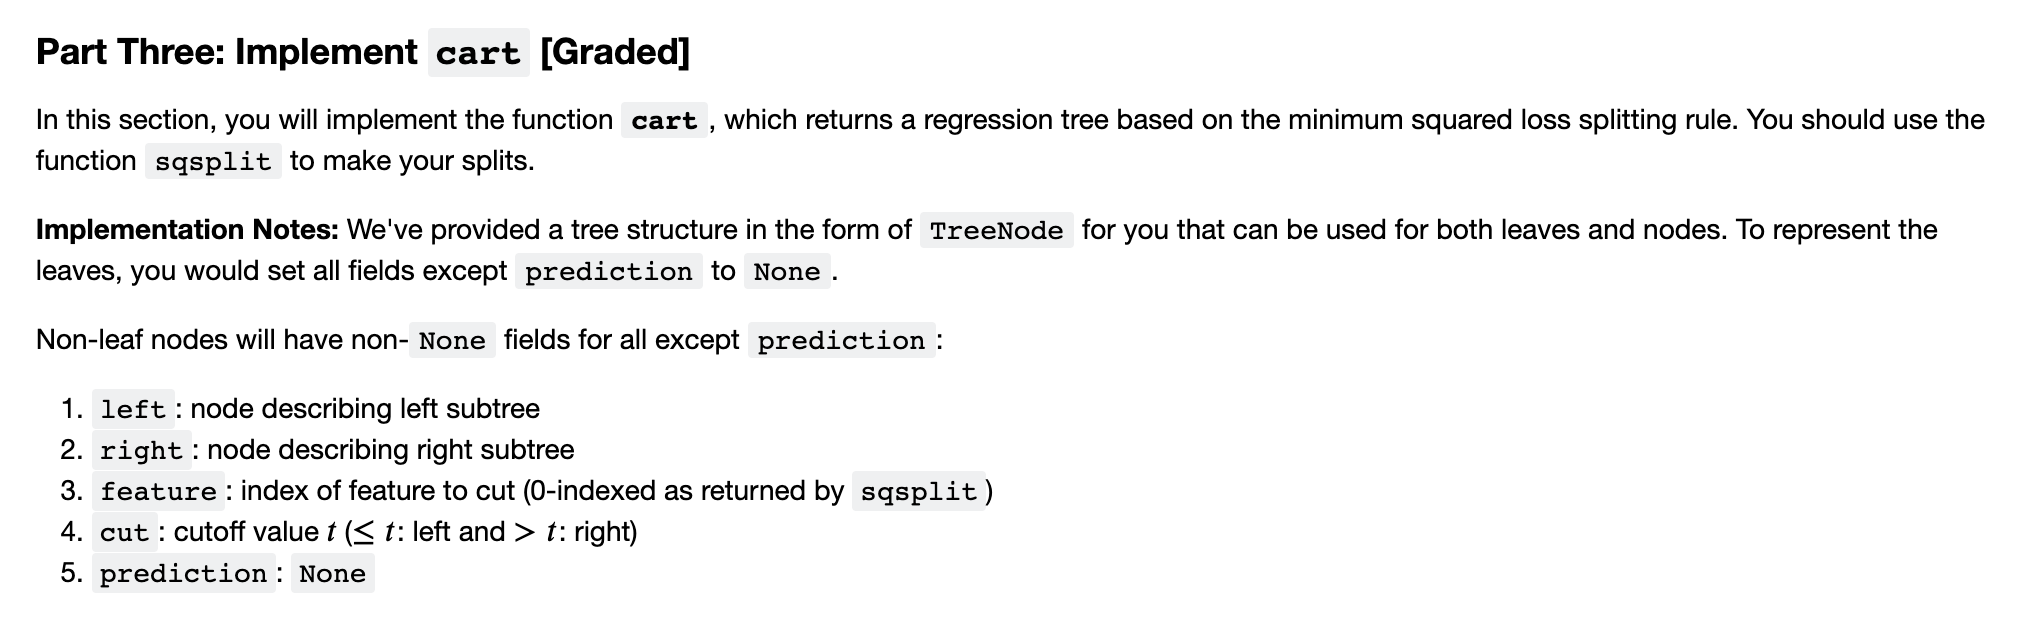

In [ ]:
class TreeNode(object):
    """
    Tree class.

    (You don't _need_ to add any methods or fields here but feel
    free to if you like. The tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """

    def __init__(self, left, right, feature, cut, prediction):
        # Check that all or no arguments are None
        node_or_leaf_args = [left, right, feature, cut]
        assert all([arg == None for arg in node_or_leaf_args]) or all([arg != None for arg in node_or_leaf_args])

        # Check that all None <==> leaf <==> prediction not None
        # Check that all non-None <==> non-leaf <==> prediction is None
        if all([arg == None for arg in node_or_leaf_args]):
            assert prediction != None
        if all([arg != None for arg in node_or_leaf_args]):
            assert prediction == None

        self.left = left
        self.right = right
        self.feature = feature
        self.cut = cut
        self.prediction = prediction

In [ ]:
# The following is a tree that predicts everything as zero ==> prediction 0
# In this case, it has no left or right children (it is a leaf node) ==> left = None, right = None, feature = None, cut = None
root = TreeNode(None, None, None, None, 0)


# The following that a tree with depth 2 or a tree with one split

# The tree will return a prediction of 1 if an example falls under the left subtree
# Otherwise it will return a prediction of 2
# To start, first create two leaf node
left_leaf = TreeNode(None, None, None, None, 1)
right_leaf = TreeNode(None, None, None, None, 2)

# Now create the parent or the root
# Suppose we split at feature 0 and cut of 1 and the prediction is None
root2 = TreeNode(left_leaf, right_leaf, 0, 1, None)

# Now root2 is the tree we desired

Now implement the function cart using **recursion** (you call cart on the left and right subtrees inside the cart function). Recall the pseudocode for the CART algorithm.

NOTE: In this implementation, you will be using np.mean for prediction argument. To check that floating point values in xTr are the same or not, you can use **np.isclose(xTr, xTr[0])**, which returns a list of True and False based on how different the rows of xTr are from the vector xTr[0].

**bold text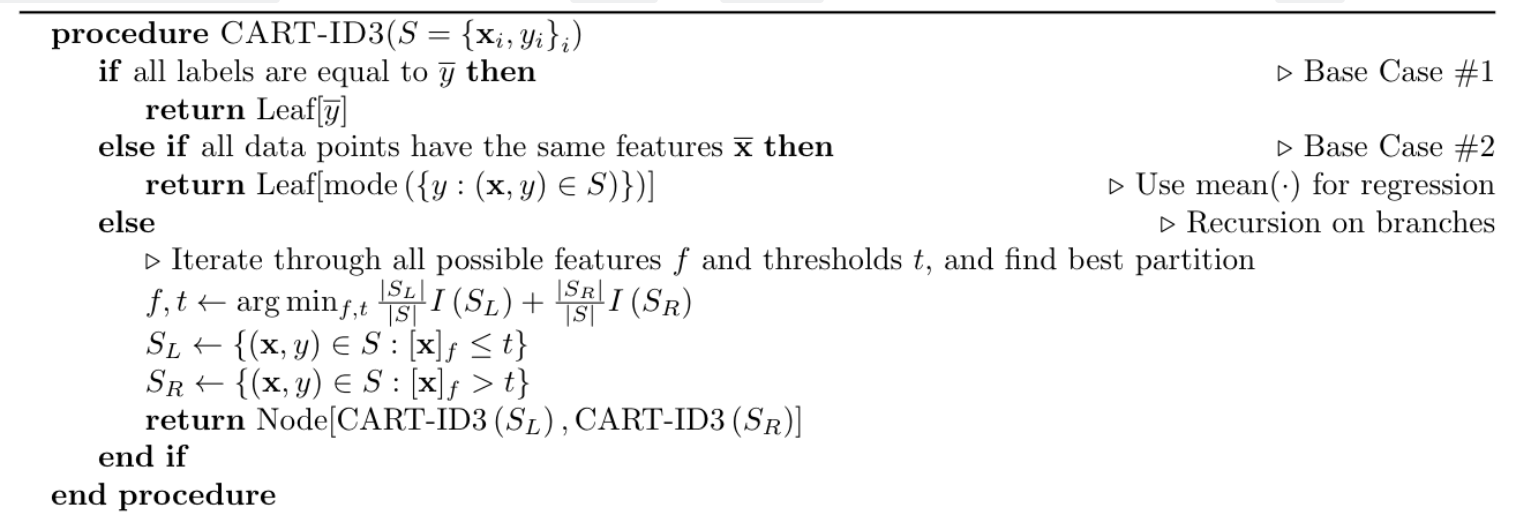**

In [ ]:
def cart(xTr, yTr):
    """
    Builds a CART tree.

    Input:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector

    Output:
        tree: root of decision tree
    """
    n, d = xTr.shape
    node = None

    def mode(M):
      distinct_numbers = np.unique(M, axis = None)
      max_count = 0
      mode = None

      for n in distinct_numbers:
        c = np.count_nonzero(M == n)
        if c > max_count:
          max_count = c
          mode = n
      return mode

    if np.all(yTr == np.mean(yTr, axis = None)) == True: #if all labels are equal to the mean
      return TreeNode(None, None, None, None, float(np.mean(yTr, axis = 0))) #return a leaf that predicts the mean of the label
    elif np.all(np.isclose(xTr, xTr[0])) == True: #if all data points have the same feature values e.g. compared to those of its first row
      return TreeNode(None, None, None, None, mode(yTr)) #return a leaf that predicts the mode of the label
    else:
      feature, cut, bestloss = sqsplit(xTr, yTr) #iterate through all features and thresholds to find the one that minimises the bestloss the most
      Sl = yTr[xTr[:,feature]<cut] #create Sl labels based on the splitting of the data by the cut on that feature
      Sr = yTr[xTr[:,feature]>=cut] #create Sr labels based on the splitting of the data by the cut on that feature
      #create two leaves that predict the mean label of Sl and Sr respectively, left = None, right = None, feature = None, cut = None, prediction = mean of labels
      left_child = cart(xTr[xTr[:,feature]<cut], yTr[xTr[:,feature]<cut])
      right_child = cart(xTr[xTr[:,feature]>=cut], yTr[xTr[:,feature]>=cut])

    return TreeNode(left_child, right_child, feature, cut, None) #return the root node with the splitting criteria

In [ ]:
#another implementation of the code that hopefully will resolve the erros
def mode(M):
  distinct_numbers = np.unique(M, axis = None)
  max_count = 0
  mode = None
  for n in distinct_numbers:
    c = np.count_nonzero(M==n)
    if c > max_count:
      max_count = c
      mode = n
  return mode

def cart(xTr, yTr):
  if np.all(yTr == np.mean(yTr, axis = None)):
    return TreeNode(None, None, None, None, float(np.mean(yTr, axis = None)))
  elif np.all(np.isclose(xTr, xTr[0])):
    return TreeNone(None, None, None, None, mode(yTr))
  else:
    feature, cut, bestloss = sqsplit(xTr, yTr)
    left_child = cart(xTr[xTr[:,feature] <= cut], yTr[xTr[:,feature] <= cut])
    right_child = cart(xTr[xTr[:,feature]>cut], yTr[xTr[:,feature]>cut])
  return TreeNode(left_child, right_child, feature, cut, None)

In [ ]:
#use np.mean instead for regression, rather than mode, working code

def cart(xTr, yTr):
  if np.all(yTr == np.mean(yTr, axis = None)):
    return TreeNode(None, None, None, None, float(np.mean(yTr, axis = None)))
  elif np.all(np.isclose(xTr, xTr[0])):
    return TreeNode(None, None, None, None, float(np.mean(yTr, axis = None)))
  else:
    feature, cut, bestloss = sqsplit(xTr, yTr)
    left_child = cart(xTr[xTr[:,feature] <= cut], yTr[xTr[:,feature] <= cut])
    right_child = cart(xTr[xTr[:,feature]>cut], yTr[xTr[:,feature]>cut])
  return TreeNode(left_child, right_child, feature, cut, None)

In [ ]:
cart(xTr, yTr)

this is the: 0 column
this is the cut: 0.5 for this column:0
this is the Sl: [1] dataset
this is the Sr: [ 1  1 -1] dataset
this is the number of labels: 1
this is the number of labels: 3
this is the cut: 1.5 for this column:0
this is the Sl: [1 1] dataset
this is the Sr: [ 1 -1] dataset
this is the number of labels: 2
this is the number of labels: 2
this is the: 1 column
this is the cut: 0.5 for this column:1
this is the Sl: [1 1 1] dataset
this is the Sr: [-1] dataset
this is the number of labels: 3
this is the number of labels: 1
this is the: 2 column
this is the cut: 1.5 for this column:2
this is the Sl: [1 1] dataset
this is the Sr: [ 1 -1] dataset
this is the number of labels: 2
this is the number of labels: 2


In [ ]:
np.mean(yTr, axis = 0)

0.5

In [ ]:
float(np.mean(yTr, axis=0))

0.5

In [ ]:
float(np.mean(yTr, axis=None))

0.5

In [ ]:
yTr == np.mean(yTr, axis = None)

array([False, False, False, False])

In [ ]:
xTr

array([[1, 0, 2],
       [2, 0, 1],
       [0, 0, 1],
       [2, 1, 2]])

In [ ]:
xTr[0]

array([1, 0, 2])

In [ ]:
np.isclose(xTr, xTr[0])

array([[ True,  True,  True],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True]])

In [ ]:
if all(val == True for val in np.isclose(xTr, xTr[0]):
  print(f'All true')
else:
  print(f'Not all true')

All true


In [ ]:
np.all(np.isclose(xTr, xTr[0]))

False

In [ ]:
if np.all(np.isclose(xTr, xTr[0])) == True:
  print(f'All true')
else:
  print(f'Not all true')


Not all true


In [ ]:
from scipy.stats import mode as modescipy
    def mode(M):
      return modescipy(M, keepdims = True)

In [ ]:
def mode(M):
  return modescipy(M, keepdims = True)

In [ ]:
mode(yTr)

ModeResult(mode=array([1]), count=array([3]))

In [ ]:
yTr

array([ 1,  1,  1, -1])

In [ ]:
mode(yTr)[0][0]

1

In [ ]:
Sl = yTr[xTr[:,1]<0.5]
print(Sl)

[1 1 1]


In [ ]:
TreeNode(None, None, None, None, np.mean(Sl, axis = None))

In [ ]:
def mode(a):
    return max(a,key=a.count)[0]

In [ ]:
def mode(M):
    distinct_numbers = np.unique(M, axis = None)
    max_count = 0
    mode = None

    for n in distinct_numbers:
        c = np.count_nonzero(M == n)
        if c > max_count:
            max_count = c
            mode = n
    return mode

In [ ]:
print(mode(yTr))

1


In [ ]:
np.unique(yTr, axis = None)

array([-1,  1])

In [ ]:
np.count_nonzero(yTr == -1)

1

In [ ]:
np.count_nonzero(yTr == 1)

3

In [ ]:
mode(yTr)

In [ ]:
# The tests below check that your implementation of cart  returns the correct predicted values for a sample dataset

#test case 1
def cart_test1():
    t=cart(xor4,yor4)
    return DFSxor(t)

#test case 2
def cart_test2():
    y = np.random.rand(16);
    t = cart(xor4,y);
    yTe = DFSpreds(t)[:];
    # Check that every label appears exactly once in the tree
    y.sort()
    yTe.sort()
    return np.all(np.isclose(y, yTe))

#test case 3
def cart_test3():
    xRep = np.concatenate([xor2, xor2])
    yRep = np.concatenate([yor2, 1-yor2])
    t = cart(xRep, yRep)
    return DFSxorUnsplittable(t)

#test case 4
def cart_test4():
    X = np.ones((5, 2)) # Create a dataset with identical examples
    y = np.ones(5)

    # On this dataset, your cart algorithm should return a single leaf
    # node with prediction equal to 1
    t = cart(X, y)

    # t has no children
    children_check = (t.left is None) and (t.right is None)

    # Make sure t does not cut any feature and at any value
    feature_check = (t.feature is None) and (t.cut is None)

    # Check t's prediction
    prediction_check = np.isclose(t.prediction, 1)
    return children_check and feature_check and prediction_check

#test case 5
def cart_test5():
    X = np.arange(4).reshape(-1, 1)
    y = np.array([0, 0, 1, 1])

    t = cart(X, y) # your cart algorithm should generate one split

    # check whether you set t.feature and t.cut to something
    return t.feature is not None and t.cut is not None

In [ ]:
xTest = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
yTest = np.array([1, 1, -1])
cart(xTest, yTest)

NameError: ignored

### Part Four: Implement `evaltree` [Graded]

Implement the function **`evaltree`**, which evaluates a decision tree on a given test data set. You essentially need to traverse the tree until you end up in a leaf, where you return the `prediction` value of the leaf. Like the `cart` function, you can call `evaltree` on the left subtree and right subtree on testing points that fall in the corresponding subtrees.

Here's some inspiration:
1. If the `tree` is a leaf, i.e. the left and right subtrees are `None`, return `tree.prediction` for all `m` testing points.
2. If the `tree` is non-leaf, using `tree.feature` and `tree.cut` find testing points with the feature value less than/equal to the threshold and greater than. Now, you can call `evaltree` on `tree.left` and the left set of testing points to obtain the left set's predictions. Then obtain the predictions for the right set, and return all predictions.

In [ ]:
def evaltree(tree, xTe):
    """
    Evaluates testing points in xTe using decision tree root.

    Input:
        tree: TreeNode decision tree
        xTe:  m x d matrix of data points

    Output:
        pred: m-dimensional vector of predictions
    """
    m, d = xTe.shape
    preds = np.zeros(m)

    if tree.left is None and tree.right is None:
        preds[:] = tree.prediction
    else:
      left_preds = np.zeros(m)
      right_preds = np.zeros(m)
      for i in range(m):
          if xTe[i,tree.feature] <= tree.cut:
              Sl = xTe[xTe[:,tree.feature] <= tree.cut]
              left_preds[i] = evaltree(tree.left, Sl)
          if xTe[i,tree.feature] > tree.cut:
              Sr = xTe[xTe[:,tree.feature] > tree.cut]
              right_preds[i] = evaltree(tree.right, Sr)
      preds[xTe[:,tree.feature] <= tree.cut] = left_preds[xTe[:,tree.feature] <= tree.cut]
      preds[xTe[:,tree.feature] > tree.cut] = right_preds[xTe[:,tree.feature] > tree.cut]
    return preds

In [ ]:
#alternative code that hopefully will fix Value Error

def evaltree(tree, xTe, preds=None):
  """
    Evaluates testing points in xTe using decision tree root.

    Input:
        tree: TreeNode decision tree
        xTe:  m x d matrix of data points

    Output:
        pred: m-dimensional vector of predictions
  """
  if preds is None:
    m, d = xTe.shape
    preds = np.zeros(m)

  if tree.left is None and tree.right is None:
    preds[:] = tree.prediction

  else:
    left_mask = xTe[:, tree.feature] <= tree.cut
    right_mask = xTe[:, tree.feature] > tree.cut

    left_preds = np.zeros(np.sum(left_mask))
    right_preds = np.zeros(np.sum(right_mask))

    if np.sum(left_mask) >0:
      Sl = xTe[left_mask]
      left_preds = evaltree(tree.left, Sl, left_preds)

    if np.sum(right_mask) >0:
      Sr = xTe[right_mask]
      right_preds = evaltree(tree.right, Sr, right_preds)

    preds[left_mask] = left_preds
    preds[right_mask] = right_preds

  return preds

In [ ]:
#working code
def evaltree(tree, xTe):
    """
    Evaluates testing points in xTe using decision tree root.

    Input:
        tree: TreeNode decision tree
        xTe:  m x d matrix of data points

    Output:
        pred: m-dimensional vector of predictions
    """
    m, d = xTe.shape
    preds = np.zeros(m)

    if tree.left is None and tree.right is None:
        preds[:] = tree.prediction
    else:
        left_mask = xTe[:, tree.feature] <= tree.cut
        right_mask = xTe[:, tree.feature] > tree.cut

        left_preds = np.zeros(np.sum(left_mask))
        right_preds = np.zeros(np.sum(right_mask))

        if np.sum(left_mask) >0:
            Sl = xTe[left_mask]
            left_preds = evaltree(tree.left, Sl)

        if np.sum(right_mask) >0:
            Sr = xTe[right_mask]
            right_preds = evaltree(tree.right, Sr)

        preds[left_mask] = left_preds
        preds[right_mask] = right_preds

    return preds

# Training and Testing a Classification Tree on the ION Dataset
The following code create a classification tree on the ION dataset and then apply the learned tree to an unknown dataset. If you implement everything correctly, you should get a training RSME that is close to zero.

In [ ]:
t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

NameError: ignored

# Visualize Your Tree
The following code defines a function visclassifier(), which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set.

In [ ]:
def visclassifier(fun,xTr,yTr,w=None,b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()


    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T


    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )

    if w is not None:
        w = np.array(w).flatten()
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data
visclassifier(lambda X:evaltree(tree,X), xTrSpiral, yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

Streaming output truncated to the last 5000 lines.
  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.] dataset
this is the number of labels: 3
this is the number of labels: 72
this is the cut: -3.4599119758793826 for this column:0
this is the Sl: [ 1. -1.  1. -1.] dataset
this is the Sr: [-1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1.
  1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.] dataset
this is the number of labels: 4
this is the number of labels: 71
this is the cut: -3.1944716246812312 for this column:0
this is the Sl: [ 1. -1.  1. -1. -1.] dataset
this is the Sr: [-1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.
 -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1.

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]])
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)

    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)


    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()

%matplotlib notebook
xTraining= np.array([[5,6]])
labels = [1]
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Click to add positive points and use shift-click to add negative points.')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Click to add positive points and use shift-click to add negative points.')

**Scikit-learn**
Scikit-learn also provides an implementation of Regression Trees (and Decision Tree Classifiers). The usage is pretty straight-forward: define the regression tree with the impurity function (and other settings), fit to the training set, and evaluate on any dataset.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

t0 = time.time()
tree = DecisionTreeRegressor(
    criterion='squared_error', # Impurity function = Mean Squared Error (squared loss)
    splitter='best', # Take the best split
    max_depth=None, # Expand the tree to the maximum depth possible
)
tree.fit(xTrSpiral, yTrSpiral)
t1 = time.time()

tr_err   = np.mean((tree.predict(xTrSpiral) - yTrSpiral)**2)
te_err   = np.mean((tree.predict(xTeSpiral) - yTeSpiral)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

Elapsed time: 0.00 seconds
Training RMSE : 0.00
Testing  RMSE : 0.35 



Scikit-learn also provides a tree plotting function, which is again quite simple to use. This is extremely useful while debugging a decision tree.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
_ = plot_tree(tree, ax=ax, precision=2, feature_names=[f'$[\mathbf{{x}}]_{i+1}$' for i in range(2)], filled=True)

<IPython.core.display.Javascript object>

# Cross Validation
In this project, you will implement cross validation to pick the best depth (hyperparameter) for a regression tree, again using the ION dataset.

In [ ]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

%matplotlib notebook

from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.10.11


In [ ]:
%matplotlib notebook
M = dlread('ionosphere.txt')
save('ionosphere.mat', M)

NameError: ignored

In [ ]:
data = loadmat("ionosphere.mat")
xTr  = data['xTr'].T
yTr  = data['yTr'].flatten()
xTe  = data['xTe'].T
yTe  = data['yTe'].flatten()
print(f'Number of features: {xTr.shape[1]}')
print(f'Number of training points: {xTr.shape[0]}')
print(f'Number of testing points: {xTe.shape[0]}')

FileNotFoundError: ignored

Number of features: 34

Number of training points: 281

Number of testing points: 70

You are provided a regression-tree-based classifier to use. In addition to what you implemented in the first project, we added a depth hyperparameter to the classifier, specified as an argument. This depth argument allows us to restrict the maximum depth of the tree model.

The following code cell shows you how to instantiate a regression tree.

In [ ]:
# Create a regression tree with no restriction on its depth.
# This is equivalent to what you implemented in the previous project

# **If you want to create a tree of max depth k, then call RegressionTree(depth=k)**
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTr, yTr)

# To use the trained regression tree to make prediction
pred = tree.predict(xTr)

NameError: ignored

We have also created a square loss function that takes in the prediction pred and ground truth truth and returns the average square loss between prediction and ground truth.

In [ ]:
def square_loss(pred, truth):
    """
    Calculates the loss between predicted and true labels.

    Input:
        pred: n-dimensional vector of predicted labels
        truth: n-dimensional vector of true labels

    Output:
        loss: average squared loss
    """
    return np.mean((pred - truth)**2)

Now, look at the performance of your tree on both the training set and test set using the code cell below.

In [ ]:
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

# Implement Cross Validation
As you can see, your tree achives zero training loss on the training set but not zero test loss. Clearly, the tree is overfitting! To reduce overfitting, you need to control the depth of the tree.

One way to pick the optimal depth is to do  𝑘
 -Fold Cross Validation. To do so, you will first implement grid_search, which finds the best depths given a training set and validation set. Then you will implement generate_kFold, which generates a pair of training and validation set for grid search. Finally, you will combine the two functions by implementing cross_validation.

# Part One: Implement grid_search [Graded]
Implement the function grid_search, which takes in a training set xTr, yTr, a validation set xVal, yVal and a list of tree depth candidates depths. Your job here is to fit a regression tree for each depth candidate on the training set xTr, yTr, evaluate the fitted tree on the validation set xVal, yVal, and then pick the candidate that yields the lowest loss for the validation set.

Implementation Notes:

Use the square_loss function to calculate the training and validation loss for corresponding predictions against true labels yTr and yVal respectively.
In the event of a tie, return the depth that appears first in depths list (np.argmin on the list of validation losses will give you the first index in case of a tie).

In [ ]:
def grid_search(xTr, yTr, xVal, yVal, depths):
    """
    Calculates the training and validation loss for trees trained on xTr and validated on yTr with a number of depths.

    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        xVal: mxd validation data matrix
        yVal: m-dimensional vector of validation labels
        depths: a list of len k of depths

    Output:
        best_depth, training_losses, validation_losses
        best_depth: the depth that yields that lowest validation loss
        training_losses: a list of len k. the i-th entry corresponds to the the training loss of the tree of depth=depths[i]
        validation_losses: a list of len k. the i-th entry corresponds to the the validation loss of the tree of depth=depths[i]
    """
    training_losses = []
    validation_losses = []
    best_depth = None

    for i in range(len(depths)):
        tree = RegressionTree(depth=depths[i])
        tree.fit(xTr, yTr)
        training_losses.append(square_loss(tree.predict(xTr), yTr))
        validation_losses.append(square_loss(tree.predict(xVal), yVal))
        print(f'Validation losses has length: {len(validation_losses)}')

        if i>0 and validation_losses[i-1] < validation_losses[i]:
            best_depth = depths[i-1]

        if i>0 and validation_losses[i-1] == validation_losses[i]:
            mask = np.argmin(validation_losses)
            best_depth = depths[mask]

    return best_depth, training_losses, validation_losses

In [ ]:
training_losses.append(square_loss(tree.predict(xTr), yTr))
validation_losses.append(square_loss(tree.predict(xVal), yVal))

In [ ]:
#The error message indicates that the index used for assigning values to the training_losses and validation_losses lists is out of range.
#This error occurs because the lists are initially empty, and you're trying to assign values to specific indices without extending the lists.
#To fix this issue, you can use the append method to add elements to the end of the lists instead of assigning values to specific indices. Here's the modified code:

training_losses[i] = square_loss(tree.predict(xTr), yTr)
validation_losses[i] = square_loss(tree.predict(xVal), yVal)

SyntaxError: ignored

In [ ]:
#adapt to use sklearn.tree functions
from sklearn.tree import DecisionTreeRegressor, plot_tree

t0 = time.time()
tree = DecisionTreeRegressor(
    criterion='squared_error', # Impurity function = Mean Squared Error (squared loss)
    splitter='best', # Take the best split
    max_depth=None, # Expand the tree to the maximum depth possible
)
tree.fit(xTrSpiral, yTrSpiral)
t1 = time.time()

tr_err   = np.mean((tree.predict(xTrSpiral) - yTrSpiral)**2)
te_err   = np.mean((tree.predict(xTeSpiral) - yTeSpiral)**2)

print("Elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f \n" % te_err)

We can do a dry run with sample depths and plot the training and validation losses against the tree depth. Observe that the training loss continues to decrease with increasing depth, but the validation loss starts to increase after a minimum.

In [ ]:
depths = np.arange(10)

# 80-20 split of the training data for demo purposes here
train_split = int(0.8 * xTr.shape[0])
best_depth, training_losses, validation_losses = grid_search(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)

plt.plot(depths, training_losses, label='training')
plt.plot(depths, validation_losses, label='validation')
plt.xlabel('tree depth')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

print(f'Best depth: {best_depth}, validation loss: {np.min(validation_losses):.2f}')

In [ ]:
# The following tests check that your implementation of grid search returns the correct number of training and validation loss values and the correct best depth

depths = [1,2,3,4,5]
k = len(depths)

# 80-20 split of the training data
train_split = int(0.8 * xTr.shape[0])
best_depth, training_losses, validation_losses = grid_search(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)
best_depth_grader, training_losses_grader, validation_losses_grader = grid_search_grader(xTr[:train_split], yTr[:train_split], xTr[train_split:], yTr[train_split:], depths)

# Check the length of the training loss
def grid_search_test1():
    return (len(training_losses) == k)

# Check the length of the validation loss
def grid_search_test2():
    return (len(validation_losses) == k)

# Check the argmin
def grid_search_test3():
    return (best_depth == depths[np.argmin(validation_losses)])

def grid_search_test4():
    return (best_depth == best_depth_grader)

def grid_search_test5():
    return np.linalg.norm(np.array(training_losses) - np.array(training_losses_grader)) < 1e-7

def grid_search_test6():
    return np.linalg.norm(np.array(validation_losses) - np.array(validation_losses_grader)) < 1e-7

runtest(grid_search_test1, 'grid_search_test1')
runtest(grid_search_test2, 'grid_search_test2')
runtest(grid_search_test3, 'grid_search_test3')
runtest(grid_search_test4, 'grid_search_test4')
runtest(grid_search_test5, 'grid_search_test5')
runtest(grid_search_test6, 'grid_search_test6')

# Part Two: Implement generate_kFold[Graded]
Now, implement the generate_kFold function, which takes in the number of training examples n and the number of folds k and returns a list of k folds, where each fold takes the form (training indices, validation indices).

For instance, if n = 3 and k = 3, then we have three indices [0, 1, 2] and we are trying to split it k = 3 times to obtain different training/validation splits. One possible output of the the function is [ ([0, 1], [2]), ([1, 2], [0]), ([0, 2], [1]) ]. It is possible that k might not divide n with remainder 0. In that case, you can divide n k-1 times fully and have the remainder constitute the final fold. For instance, if n = 5 and k = 4, one possible output is [ ([1, 2, 3, 4], [0]), ([0, 2, 3, 4], [1]), ([0, 1, 3, 4], [2]), ([0, 1, 2], [3, 4]) ].

**Ensure that no two folds have the same indices **as it is wasteful to train a model on the same training/validation split again.

One possible algorithm: divide the list of n indices into k parts and loop k times, collecting all but 1 parts into the training set for that fold and leaving that part as the validation set.

In [ ]:
def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.

    Input:
        n: number of training examples
        k: number of folds

    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []

    indices = list(range(n))

    #divide the list of n indices into k parts and loop k times, collecting all but 1 parts into the training set for that fold and leaving that part as the validation set.

    # Ensure that no two folds have the same indices

    if np.remainder(n,k) == 0:
      for i in range(k):
        validation_indices = indices[i]
        training_indices = np.delete(indices, [i], 0)
        kfold_indices += [training_indices, validation_indices]

    if np.remainder(n,k) != 0:
      for i in range (k-1):
        validation_indices = indices[i]
        training_indices = np.delete(indices, [i], 0)
        kfold_indices += [training_indices, validation_indices]

    return kfold_indices

In [ ]:
generate_kFold(3,3)

[array([1, 2]), 0, array([0, 2]), 1, array([0, 1]), 2]

In [ ]:
n = 3
k = 3
a = np.array([[1,2,3],[4,5,6]])

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
indices = list(range(3))
print(indices)

[0, 1, 2]


In [ ]:
np.delete(indices, [1], 0)

array([0, 2])

In [ ]:
import numpy as np

def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.

    Input:
        n: number of training examples
        k: number of folds

    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []
    indices = list(range(n))

    if np.remainder(n, k) == 0:
        fold_size = n // k

        for i in range(k):
            validation_indices = indices[i * fold_size: (i + 1) * fold_size]
            training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
            kfold_indices.append((training_indices, validation_indices))

    else:
        fold_size = n // (k - 1)
        last_fold_size = n%k

        for i in range(k - 1):
            validation_indices = indices[i * fold_size: (i + 1) * fold_size]
            training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
            kfold_indices.append((training_indices, validation_indices))

        validation_indices = indices[(k - 1) * fold_size:]
        training_indices = indices[:(k - 1) * fold_size]
        kfold_indices.append((training_indices, validation_indices))

    return kfold_indices

In [ ]:
generate_kFold(5,4)

[([1, 2, 3, 4], [0]),
 ([0, 2, 3, 4], [1]),
 ([0, 1, 3, 4], [2]),
 ([0, 1, 2], [3, 4])]

In [ ]:
generate_kFold(19,3)

[([9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [0, 1, 2, 3, 4, 5, 6, 7, 8]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 18], [9, 10, 11, 12, 13, 14, 15, 16, 17]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [18])]

In [ ]:
kfold_indices = generate_kFold(1004,5)

In [ ]:
def generate_kFold_test3():
    ratio_validation = []
    for (train_indices, validation_indices) in kfold_indices:
        ratio = len(validation_indices) / len(train_indices)
        ratio_validation.append((ratio > 0.24 and ratio < 0.26))
    # make sure that for each fold, the training to validation
    # examples ratio is in between 0.24 and 0.25
    return np.all(ratio_validation)

In [ ]:
generate_kFold_test3()

False

In [ ]:
fold_size = 5 // 3
print(fold_size)

1


In [ ]:
last_fold_size = 5 - 1 * (3)
print(last_fold_size)

2


In [ ]:
np.remainder(5, 3)

2

In [ ]:
def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.

    Input:
        n: number of training examples
        k: number of folds

    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []
    indices = list(range(n))

    if np.remainder(n, k) == 0:
        fold_size = n // k

        for i in range(k):
          validation_indices = indices[i * fold_size: (i + 1) * fold_size]
          training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
          kfold_indices.append((training_indices, validation_indices))

    else:
      fold_size = n // (k - 1)
      last_fold_size = n - fold_size*(k-1)

      for i in range(k - 1):
        validation_indices = indices[i * fold_size: (i + 1) * fold_size]
        training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size: (i + 1) * fold_size + last_fold_size]
        kfold_indices.append((training_indices, validation_indices))

      validation_indices = indices[(k - 1) * fold_size:]
      training_indices = indices[:(k - 1) * fold_size]
      kfold_indices.append((training_indices, validation_indices))

    return kfold_indices

In [ ]:
generate_kFold(5,4)

[([1, 2], [0]), ([0, 2, 3], [1]), ([0, 1, 3, 4], [2]), ([0, 1, 2], [3, 4])]

In [ ]:
#also working code
def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.

    Input:
        n: number of training examples
        k: number of folds

    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []
    indices = list(range(n))

    if np.remainder(n, k) == 0:
        fold_size = n // k

        for i in range(k):
          validation_indices = indices[i * fold_size: (i + 1) * fold_size]
          training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
          kfold_indices.append((training_indices, validation_indices))

    else:
      fold_size = n // (k)
      last_fold_size = n - fold_size * (k)

      for i in range(k):
        validation_indices = indices[i * fold_size: (i + 1) * fold_size]
        training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
        kfold_indices.append((training_indices, validation_indices))

      validation_indices = indices[(k - 1) * fold_size:]
      training_indices = indices[:(k - 1) * fold_size]
      kfold_indices.append((training_indices, validation_indices))

    return kfold_indices

In [ ]:
generate_kFold(5,4)

[([1, 2, 3, 4], [0]),
 ([0, 2, 3, 4], [1]),
 ([0, 1, 3, 4], [2]),
 ([0, 1, 2, 4], [3]),
 ([0, 1, 2], [3, 4])]

In [ ]:
generate_kFold(20,3)

[([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [0, 1, 2, 3, 4, 5]),
 ([0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19], [6, 7, 8, 9, 10, 11]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19], [12, 13, 14, 15, 16, 17]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19])]

In [ ]:
#working code
import numpy as np

def generate_kFold(n, k):
    """
    Generates [(training_indices, validation_indices), ...] for k-fold validation.

    Input:
        n: number of training examples
        k: number of folds

    Output:
        kfold_indices: a list of length k. Each entry takes the form (training indices, validation indices)
    """
    assert k >= 2
    kfold_indices = []
    indices = list(range(n))

    if np.remainder(n, k) == 0:
        fold_size = n // k

        for i in range(k):
            validation_indices = indices[i * fold_size: (i + 1) * fold_size]
            training_indices = indices[:i * fold_size] + indices[(i + 1) * fold_size:]
            kfold_indices.append((training_indices, validation_indices))

    else:
        fold_size = n // k
        remainder = n % k
        start_index = 0

        for i in range(k):
            if i < remainder:
                end_index = start_index + fold_size + 1
            else:
                end_index = start_index + fold_size

            validation_indices = indices[start_index:end_index]
            training_indices = indices[:start_index] + indices[end_index:]
            kfold_indices.append((training_indices, validation_indices))

            start_index = end_index

    return kfold_indices

In [ ]:
generate_kFold(5,4)

[([2, 3, 4], [0, 1]),
 ([0, 1, 3, 4], [2]),
 ([0, 1, 2, 4], [3]),
 ([0, 1, 2, 3], [4])]

In [ ]:
generate_kFold(11,4)

[([3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2]),
 ([0, 1, 2, 6, 7, 8, 9, 10], [3, 4, 5]),
 ([0, 1, 2, 3, 4, 5, 9, 10], [6, 7, 8]),
 ([0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10])]

# Part Three: Implement cross_validation [Graded]
Use grid_search to implement the cross_validation function, which takes in the training set xTr, yTr, a list of depth candidates depths and performs 𝑘
-Fold Cross Validation on the training set.

We will use generate_kFold to generate the 𝑘
 training/validation splits and pass in the indices for the splits to the cross_validation function. Therefore, for each (training_indices, validation_indices) element in indices, you need to** perform grid search to find the training and validation loss for each depth for that fold.** Finally, take the average training and validation loss across folds to get the "average" loss. Your implementation should return these 2 loss vectors and the depth with the minimum average validation loss.

In [ ]:
def cross_validation(xTr, yTr, depths, indices):
    """
    Performs cross_validation on training data with trees of varying depths. The splits are specified in indices.

    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        depths: a list of length l of depths to be tried out
        indices: indices [(training_indices, validation_indices), ...] from generate_kFold,
            specifying the splits for each fold (length k)

    Output:
        best_depth: the depth corresponding to the minimum average validation loss.
        training_losses: a list of length l. the i-th entry corresponds to the the average training loss of the tree of depth=depths[i]
        validation_losses: a list of length l. the i-th entry corresponds to the the average validation loss of the tree of depth=depths[i]
    """
    training_losses = []
    validation_losses = []
    best_depth = None

    n = np.size(yTr)
    n, d = np.shape(xTr)
    k = np.size(indices)
    l = np.size(depths)

    for fold_indices in indices:
        training_indices, validation_indices = fold_indices

        xTrain = xTr[training_indices]
        yTrain = yTr[training_indices]
        xVal = xTr[validation_indices]
        yVal = yTr[validation_indices]

        fold_best_depth, fold_training_losses, fold_validation_losses = grid_search(xTrain, yTrain, xVal, yVal, depths) #depths is a list here and fold_training losses is also a list..

        training_losses.append(fold_training_losses)
        validation_losses.append(fold_validation_losses)

    # Calculate the average training and validation losses across folds
    average_training = np.mean(training_losses)
    average_validation = np.mean(validation_losses)

    # Find the index of the depth with the minimum average validation loss
    best_depth_idx = np.argmin(average_validation)
    best_depth = depths[best_depth_idx]

    return average_training, average_validation, best_depth

In [ ]:
#Alternative implementation


In [ ]:
xTr = [(1,2),(3,4),(5,6)]
xTr

[(1, 2), (3, 4), (5, 6)]

In [ ]:
yTr = [1,1]
yTr

[1, 1]

In [ ]:
 depths = [0,1]

In [ ]:
indices = generate_kFold(3,3)
indices

[([1, 2], [0]), ([0, 2], [1]), ([0, 1], [2])]

In [ ]:
cross_validation(xTr, yTr, depths, indices)

TypeError: ignored

In [ ]:
import numpy as np

def cross_validation(xTr, yTr, depths, indices):
    """
    Performs cross_validation on training data with trees of varying depths. The splits are specified in indices.

    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        depths: a list of length l of depths to be tried out
        indices: indices [(training_indices, validation_indices), ...] from generate_kFold,
            specifying the splits for each fold (length k)

    Output:
        best_depth: the depth corresponding to the minimum average validation loss.
        training_losses: a list of length l. the i-th entry corresponds to the average training loss of the tree of depth=depths[i]
        validation_losses: a list of length l. the i-th entry corresponds to the average validation loss of the tree of depth=depths[i]
    """
    training_losses = []
    validation_losses = []
    best_depth = None

    for depth in depths:
        training_loss = 0.0
        validation_loss = 0.0

        for fold_indices in indices:
            training_indices, validation_indices = fold_indices

            xTrain = xTr[training_indices]
            yTrain = yTr[training_indices]
            xVal = xTr[validation_indices]
            yVal = yTr[validation_indices]

            # Train a decision tree with the current depth
            tree = CARTDecisionTree(max_depth=depth)
            tree.train(xTrain, yTrain)

            # Calculate training and validation losses
            training_loss += tree.calculate_loss(xTrain, yTrain)
            validation_loss += tree.calculate_loss(xVal, yVal)

        # Calculate the average training and validation losses for the current depth
        training_loss /= len(indices)
        validation_loss /= len(indices)

        # Append the losses to the respective lists
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)

    # Find the index of the depth with the minimum average validation loss
    best_depth_idx = np.argmin(validation_losses)
    best_depth = depths[best_depth_idx]

    return best_depth, training_losses, validation_losses

In [ ]:
# Create a regression tree with no restriction on its depth.
# This is equivalent to what you implemented in the previous project

# **If you want to create a tree of max depth k, then call RegressionTree(depth=k)**
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTr, yTr)

# To use the trained regression tree to make prediction
pred = tree.predict(xTr)

In [ ]:
#WORKING CODE
def cross_validation(xTr, yTr, depths, indices):
    """
    Performs cross_validation on training data with trees of varying depths. The splits are specified in indices.

    Input:
        xTr: nxd training data matrix
        yTr: n-dimensional vector of training labels
        depths: a list of length l of depths to be tried out
        indices: indices [(training_indices, validation_indices), ...] from generate_kFold,
            specifying the splits for each fold (length k)

    Output:
        best_depth: the depth corresponding to the minimum average validation loss.
        training_losses: a list of length l. the i-th entry corresponds to the average training loss of the tree of depth=depths[i]
        validation_losses: a list of length l. the i-th entry corresponds to the average validation loss of the tree of depth=depths[i]
    """
    training_losses = []
    validation_losses = []
    best_depth = None

    for depth in depths:
        fold_training_losses = []
        fold_validation_losses = []

        for fold_indices in indices:
            training_indices, validation_indices = fold_indices

            xTrain = xTr[training_indices]
            yTrain = yTr[training_indices]
            xVal = xTr[validation_indices]
            yVal = yTr[validation_indices]

            fold_best_depth, fold_training_loss, fold_validation_loss = grid_search(xTrain, yTrain, xVal, yVal, [depth]) #implement at a single depth

            fold_training_losses.append(fold_training_loss)
            fold_validation_losses.append(fold_validation_loss)

        # Calculate the average training and validation losses for the current depth
        average_training_loss = np.mean(fold_training_losses)
        average_validation_loss = np.mean(fold_validation_losses)

        # Append the average losses to the respective lists
        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)

    # Find the index of the depth with the minimum average validation loss
    best_depth_idx = np.argmin(validation_losses)
    best_depth = depths[best_depth_idx]

    return best_depth, training_losses, validation_losses

In [ ]:
tree = RegressionTree(depth=np.inf)
print("Learning a tree that can grow to infinite depth")
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

print()
print('Cross validate for the best Depth')
depths = [1, 3, 5, 7]
k = len(depths)
indices = generate_kFold(len(xTr), 5)
best_depth, training_losses, validation_losses = cross_validation(xTr, yTr, depths, indices)

tree = RegressionTree(depth=best_depth)
tree.fit(xTr, yTr)
print("Best Depth", best_depth)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

Learning a tree that can grow to infinite depth
Training Loss: 0.0000
Test Loss: 0.6857

Cross validate for the best Depth
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1
Validation losses has length: 1


**Best Depth 3

Training Loss: 0.2216

Test Loss: 0.5812**

# Scikit-learn
Scikit-learn has an industry-standard implementation for Cross Validation that is extensively used. The usage is also quite straight-forward.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

print("Learning a tree that can grow to infinite depth")

tree = DecisionTreeRegressor(
    criterion='mse', # Impurity function = Mean Squared Error (squared loss)
    splitter='best', # Take the best split
    max_depth=None, # Expand the tree to the maximum depth possible
)
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

print()
print('Cross validate for the best Depth')
depths = [1, 3, 5, 7]

# Define grid search with a parameter grid and number of folds
tree = GridSearchCV(
    DecisionTreeRegressor(), # model
    param_grid={
        'criterion': ['mse'],
        'splitter': ['best'],
        'max_depth': depths
    }, # grid of parameters
    cv=5, # 5 folds
    n_jobs=-1, # Run on all available cores
)
tree.fit(xTr, yTr)

print("Best Depth", tree.best_params_)

tree = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=tree.best_params_['max_depth'])
tree.fit(xTr, yTr)
print('Training Loss: {:.4f}'.format(square_loss(tree.predict(xTr), yTr)))
print('Test Loss: {:.4f}'.format(square_loss(tree.predict(xTe), yTe)))

Learning a tree that can grow to infinite depth
Training Loss: 0.0000
Test Loss: 0.8571

Cross validate for the best Depth
Best Depth {'criterion': 'mse', 'max_depth': 3, 'splitter': 'best'}
Training Loss: 0.2216
Test Loss: 0.5812

# **Load data into Python**
To load data in Python, you must first open the external file containing the data needed. You can then use the **readlines()** method, you can parse through each line in the file, assuming that each value of interest is separated by a newline character:

In [ ]:
filename = 'sample.txt'
with open(filename, 'r') as f:
    entries = [x.rstrip() for x in f.readlines() if len(x) > 0]

# Part Zero: Understand the Type of Data and Information to be Extracted from the Data [Not Graded]
For your convenience, we have split the data into training set and test set for you. The training data is in heart_disease_train.csv and the test data is in heart_disease_test.csv. You should do all your model selection on the training set and evaluate your final model on the test data. Selecting model based on the test data is considered cheating so please refrain from doing so!

Before you begin, take a look at the two csv files and attribute.txt, which contains a description of each attribute in the csv files. You can download the files for review using the links below:

heart_disease_train.csv
heart_disease_test.csv
attribute.txt

age: age in years
sex: sex (1 = male; 0 = female)
cp: chest pain type
    -- Value 1: typical angina
    -- Value 2: atypical angina
    -- Value 3: non-anginal pain
    -- Value 4: asymptomatic
trestbps: resting blood pressure (in mm Hg on admission to the  hospital)
chol: serum cholestoral in mg/dl
fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
restecg: resting electrocardiographic results
    -- Value 0: normal
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
    -- Value 1: upsloping
    -- Value 2: flat
    -- Value 3: downsloping
ca: number of major vessels (0-3) colored by flourosopy
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
label: severity of heart disease (0=healthy, 1=presence of heart disease)

# Part One: Implement load_data [Graded]
Implement a function called load_data, which will load the given .csv file and return X, y data, where X are the patients' attributes and y is the severity of the patients' heart disease. Your function should:

Open the file
Read the comma-separated columns in the first line of the .csv (remember to strip the ending delimiters '\n').
For each line except the first one, read the comma-separated column values, convert all values from str to float, and add to the data matrix (remember to strip the ending delimiters '\n').
Use the 'label' column for y if necessary.
Implementation Notes:

In any case, do not include the 'label' column in the data matrix — the model will then be able to use this feature to predict y!
The function should handle two explicit cases. With label=True, it should output the data matrix X and the corresponding label vector y; with label=False, it should output only the data matrix X.
Feel free to use pd.read_csv or other data loaders. Just make sure the returned X, y are NumPy arrays of shapes nxd and n respectively.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

sys.path.append('~/Desktop')
from helper import *

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.10.11


In [ ]:
import numpy as np
import pandas as pd

def load_data(file='heart_disease_train.csv', label=True):
    """
    Returns the data matrix and optionally the corresponding label vector.

    Input:
        file: filename of the dataset
        label: a boolean to decide whether to return the labels or not

    Output:
        X: (numpy array) nxd data matrix of patient attributes
        y: (numpy array) n-dimensional vector of labels (if label=False, y is not returned)
    """
    df = pd.read_csv(file)

    if 'label' in df.columns:
        X = df.drop('label', axis=1).values
    else:
        X = df.values

    if label:
        if 'label' in df.columns:
            y = df['label'].values
            return X, y
        else:
            raise ValueError("Label column not found in the dataset.")
    else:
        return X

FileNotFoundError: ignored

# Part Two: Picking a Metric for Evaluation [Not Graded]
Since this is a classification problem, there are multiple loss functions or metrics we can use to evaluate. We will use square_loss as our loss function since we can always cast a classification problem as regression problem. We have implemented the loss function below.

In [ ]:
def square_loss(pred, truth):
    """
    Calculates the loss between predicted and true labels.

    Input:
        pred: n-dimensional vector of predicted labels
        truth: n-dimensional vector of true labels

    Output:
        loss: average squared loss
    """
    return np.mean((pred - truth)**2)

# Part Three: Model Selection [Graded]
At this point, we have

Split the data into training set and test set
Understood and loaded the data
Picked a metric for evaluation
Now we are ready for model selection!

A data scientist would typically try different models such as perceptron, linear regression etc. For simplicity, we restrict our attention to regression tree. Implement the test function which loads the training and test sets, finds the optimal regression tree trained on heart_disease_train.csv, and returns the tree's predictions on heart_disease_test.csv. You will be evaluated based on square_loss. You will get a full score if the test loss on your classifier is less than 0.18. You may use any functions that you implemented in the previous projects.

Hint: A few things you can try: selecting the best depth to avoid overfitting, pick the optimal subset of features for your classification model etc.
Here are the functions/classes from previous projects available to you:

In [ ]:
## Regression Tree
# Create a regression with no restriction on its depth
# if you want to create a tree of depth k

# then call RegressionTree(depth=k)
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(X, y)

# To use the trained regression tree to make predictions
pred = tree.predict(X)

## k-Fold Cross Validation
depths = [1, 3]

# To generate 5 folds for X data
indices = generate_kFold(n=X.shape[0], k=5)

# To find best depth across the folds
best_depth, training_losses, validation_losses = cross_validation(X, y, depths, indices)

NameError: ignored

In [ ]:
def test():
    """
    Loads the training and test sets, trains a regression tree and outputs predictions for the test set.

    Output:
        prediction: the prediction of your classifier on the heart_disease_test.csv
    """
    prediction = None
    Xtrain, ytrain = load_data(file='heart_disease_train.csv', label=True)
    ytrain=ytrain>0
    Xtest = load_data(file='heart_disease_test.csv', label=False)

    # then call RegressionTree(depth=k)
    tree = RegressionTree(depth=np.inf)

    # To fit/train the regression tree
    tree.fit(Xtrain, ytrain)

    # To use the trained regression tree to make predictions
    pred = tree.predict(Xtrain)

    ## k-Fold Cross Validation
    depths = [1, 3]

    # To generate 5 folds for X data
    indices = generate_kFold(n=X.shape[0], k=5)

    # To find best depth across the folds
    best_depth, training_losses, validation_losses = cross_validation(Xtrain, ytrain, depths, indices)

    #retrain the regression tree using best_depth
    tree = RegressionTree(depth=best_depth)
    tree.fit(Xtrain, ytrain)

    #use best tree for predicting the test data set
    prediction = tree.predict(Xtest)

    return prediction

In [ ]:
# The following test wil check that your test function returns a loss less than 0.18 on a sample dataset
# ground truth:
gt = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

pred = test()
test_loss = square_loss(pred, gt)
print('Your test loss: {:0.4f}'.format(test_loss))

def test_loss_test():
    return (test_loss < 0.18)

runtest(test_loss_test, 'test_loss_test')